In [3]:
#Import necessary libraries
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import random
import numba
from numba import njit
import pickle

In [4]:
# Create a class to represent letter pairs and their composite relationships
class CompositeElement:
    def __init__(self, name):
        self.name = name
        self._composite = None
    
    def composite(self):
        return self._composite
    
    def set_composite(self, other):
        self._composite = other

class CompositeMapping:
    def __init__(self):
        self.elements = {}
    
    def add_pair(self, element1, element2):
        # Create CompositeElement instances if they don't exist
        if element1 not in self.elements:
            self.elements[element1] = CompositeElement(element1)
        if element2 not in self.elements:
            self.elements[element2] = CompositeElement(element2)
        
        # Set up the composite relationship
        self.elements[element1].set_composite(self.elements[element2])
        self.elements[element2].set_composite(self.elements[element1])
    
    def get_element(self, name):
        return self.elements.get(name)





def create_mapping():# Check encoding first
    
    # Create a composite mapping
    composite_mapping = CompositeMapping()
    
    # Define all the letter sets
    latin_upper = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    latin_lower = 'abcdefghijklmnopqrstuvwxyz'

    
    # Define Latin names
    latin_names_upper = [
        'ALPHA', 'BETA', 'GAMMA', 'DELTA', 'EPSILON', 'ZETA', 'ETA', 'THETA',
        'IOTA', 'KAPPA', 'LAMBDA', 'MU', 'NU', 'XI', 'OMICRON', 'PI', 'RHO',
        'SIGMA', 'TAU', 'UPSILON', 'PHI', 'CHI', 'PSI', 'OMEGA'
    ]
    latin_names_lower = [name.lower() for name in latin_names_upper]

    
    
    # 1. Latin uppercase to uppercase prime
    for letter in latin_upper:
        composite_mapping.add_pair(letter, f"{letter}_prime")
    
    # 2. Latin lowercase to lowercase prime
    for letter in latin_lower:
        composite_mapping.add_pair(letter, f"{letter}_prime")
    
    
    # 5. Latin names uppercase to uppercase prime
    for name in latin_names_upper:
        composite_mapping.add_pair(name, f"{name}_prime")
    
    # 6. Latin names lowercase to lowercase prime
    for name in latin_names_lower:
        composite_mapping.add_pair(name, f"{name}_prime")

    # 7. Numbers to uppercase prime
    for number in range(1, 100):
        composite_mapping.add_pair(str(number), f"{str(number)}_prime")
    composite_mapping.add_pair('SIX','SIX')
    
    return composite_mapping


    
composite_mapping=create_mapping()

In [5]:
# Function to get the inverse composite of a sequence, takes a sequence of names and returns the corresponding composite names in reverse order

# def inverse_composite(sequence):
#     inverse_composite=sequence[::-1]
#     for i in range(len(inverse_composite)):
#         inverse_composite[i]=composite_mapping.elements[inverse_composite[i]]._composite.name
#     return inverse_composite
@njit
def inverse_composite(sequence):
    inverse_composite=sequence[::-1]
    for i in range(len(inverse_composite)):
        if inverse_composite[i].islower():
            inverse_composite[i]=inverse_composite[i].upper()
        elif inverse_composite[i].isupper():
            inverse_composite[i]=inverse_composite[i].lower()
    return inverse_composite

In [6]:
# Function to define deletion and inversion operations,takes a DNA sequence and two sites, and returns the modified sequence
@njit
def delete_between(DNA,site_1,site_2):
    return DNA[:site_1-1]+DNA[site_2:]  
@njit
def invert_between(DNA,site_1,site_2):
    return DNA[:site_1-1]+inverse_composite(DNA[site_1-1:site_2])+DNA[site_2:] 

In [7]:
# Functions to detect sites in a DNA sequence, takes a DNA sequence and a site, and returns the start positions of the sites and the direction (forward or backward)
@njit
def detect_pair_BRA(DNA,site):
    site_length = len(site)
    diamond_positions = []
    
    
    # Slide through the DNA looking for matches
    for i in range(len(DNA) - site_length + 1):
        # Check if current window matches the site
        DNA_window=DNA[i:i+site_length]
        if DNA_window == site:
            diamond_positions.append((i,'forward'))#computer positions
        elif DNA_window == inverse_composite(site):
            diamond_positions.append((i,'backward'))#computer positions

    
    return diamond_positions
@njit
def detect_pair_KET(DNA,site):
    site_length = len(site)
    diamond_positions = []
    
    # Slide through the DNA looking for matches
    for i in range(len(DNA) - site_length + 1):
        # Check if current window matches the site
        DNA_window=DNA[i:i+site_length]
        if DNA_window == site:
            diamond_positions.append((i,'forward'))#computer positions
        elif DNA_window == inverse_composite(site):
            diamond_positions.append((i,'backward'))#computer positions
    
    return diamond_positions


In [8]:
# Function to evaluate the colour of a DNA sequence based on two choices, takes a DNA sequence and two choices (each with a number and direction) and returns the modified sequence

def evaluate_colour_IS110(DNA,choice1,choice2):

    num1, direction_1 = choice1
    num2, direction_2 = choice2
    #WLOG,make num 1 the smaller one
    if num1 > num2:
        num1, num2 = num2, num1
        direction_1, direction_2 = direction_2, direction_1
    # Determine which function to use
    
    if direction_1 == 'forward':
        if direction_1 == direction_2:
            result= delete_between(DNA,num1+2,num2+1)
        elif direction_1!=direction_2:
            result= invert_between(DNA,num1+2,num2+1)
    elif direction_1=='backward':
        if direction_1 == direction_2:
            result= delete_between(DNA,num1+2,num2+1)
        else :
            result= 'DoNotCount'
            #result= invert_between(DNA,num1+2,num2+1)
    if choice1==choice2:
        result='DoNotCount'
    return result

In [9]:
# Function to calculate the probabilities of different outcomes based on a DNA sequence and a pool of pairs
# Takes a DNA sequence, a pool of pairs, and the number of events, and returns a list called 'outcome_lists' containing Counters object that record the probabilities for each stage of the process

In [10]:
# ***What an outcome list looks like***


# [Counter({('ONE',
#            'A',
#            'ALPHA',
#            'TWO',
#            'ALPHA_prime',
#            'A_prime',
#            'THREE',
#            'A',
#            'ALPHA',
#            'FOUR',
#            'ALPHA_prime',
#            'A_prime'): 1}),

#  Counter({('ONE',
#            'A',
#            'ALPHA',
#            '2_prime',
#            'ALPHA_prime',
#            'A_prime',
#            'THREE',
#            'A',
#            'ALPHA',
#            'FOUR',
#            'ALPHA_prime',
#            'A_prime'): 0.2,
#           ('ONE', 'A', 'ALPHA', 'FOUR', 'ALPHA_prime', 'A_prime'): 0.2,
#           ('ONE',
#            'A',
#            'ALPHA',
#            '4_prime',
#            'ALPHA_prime',
#            'A_prime',
#            '3_prime',
#            'A',
#            'ALPHA',
#            '2_prime',
#            'ALPHA_prime',
#            'A_prime'): 0.2,
#           ('ONE', 'A', 'ALPHA', 'TWO', 'ALPHA_prime', 'A_prime'): 0.2,
#           ('ONE',
#            'A',
#            'ALPHA',
#            'TWO',
#            'ALPHA_prime',
#            'A_prime',
#            'THREE',
#            'A',
#            'ALPHA',
#            '4_prime',
#            'ALPHA_prime',
#            'A_prime'): 0.2}),
           
#  Counter({('ONE', 'A', 'ALPHA', '2_prime', 'ALPHA_prime', 'A_prime'): 0.28,
#           ('ONE', 'A', 'ALPHA', '4_prime', 'ALPHA_prime', 'A_prime'): 0.28,
#           ('ONE',
#            'A',
#            'ALPHA',
#            'TWO',
#            'ALPHA_prime',
#            'A_prime',
#            'THREE',
#            'A',
#            'ALPHA',
#            'FOUR',
#            'ALPHA_prime',
#            'A_prime'): 0.12,
#           ('ONE',
#            'A',
#            'ALPHA',
#            '4_prime',
#            'ALPHA_prime',
#            'A_prime',
#            '3_prime',
#            'A',
#            'ALPHA',
#            'TWO',
#            'ALPHA_prime',
#            'A_prime'): 0.08})]

In [11]:
#Calculate the possibe DNA sequences follwing one recombinases event from one input
def calculate_each_input(dna, pairs_pool, print_output=0, print_T=0):
    """
    Parameters:
    dna (list): The DNA sequence represented as a list of names.
    pairs_pool (list): A list of pairs of sites to be processed.
    print_output (int): If 1, print the output for each recombinase action.
    print_T (int): If 1, print a message when a terminal state is reached.
    
    Returns:
    tuple: A tuple containing the result Counter and the normalization factor.
    """
    thisinput = Counter()
    recombinase_acted = 0
    for pair in pairs_pool:
        #print(pair)
        BRA_sites=pair[0]
        KET_sites=pair[1]

        BRA_positions=detect_pair_BRA(dna,BRA_sites)
        KET_positions=detect_pair_KET(dna,KET_sites)

        
        for i in range(len(BRA_positions)):
            for j in range(len(KET_positions)):
                choice1,choice2 = BRA_positions[i], KET_positions[j]
                #print(choice1,choice2)
                output = evaluate_colour_IS110(dna,choice1,choice2)
                formatted_output = tuple(output)
                if print_output==1:
                    
                    print(formatted_output)
                if output!='DoNotCount':
                    recombinase_acted += 1
                    

                    #print(f"stage {whichstage} dna {dna} recombinase {recombinase_acted} output: {formatted_output}")  # !!!Remove before flight

                    thisinput[formatted_output] +=1
        #print(recombinase_acted)
    if recombinase_acted==0:
            normfactor = 1
            thisinput[tuple(dna)] = 1
            if print_T==1:
                print(tuple(dna), "Terminal state reached, no recombinase acted")
    else:
            normfactor = recombinase_acted
    return thisinput, normfactor

In [12]:
#Iterate through the DNA sequences at each stages and calculate the result 
def probability_calculation_IS110(DNA,pairs_pool,numberofevents=5,print_output=0,print_T=0):
    outcome_list=[]

    for _ in range(numberofevents):
        outcome_list.append(Counter())
    

    outcome_list[0][tuple(DNA)] = 1

    # Iterate through each stage and calculate the outcomes
    for whichstage in range(1,numberofevents):

        stage = outcome_list[whichstage-1]
        for dna,probs in stage.items():
            dna=list(dna)
            # Now work out all the things the recombinases can do
            thisinput, normfactor=calculate_each_input(dna, pairs_pool, print_output, print_T)
                
            for key in thisinput:
                outcome_list[whichstage][key] += thisinput[key]*probs/normfactor

    # Check to see if normalisation is preserved
        #print(f"Stage {whichstage} has {len(outcome_list[whichstage])} outcomes")
    return outcome_list
    


In [13]:
# Visualisation function to plot ranked probability distributions after each recombination event
def plot_ranked_probabilities(outcome_list):
    num_stages = len(outcome_list)
    fig, axes = plt.subplots(num_stages, 3, figsize=(18, 4 * num_stages), squeeze=False)

    for stage in range(num_stages):
        probs = np.array(sorted(outcome_list[stage].values(), reverse=True))
        ranks = np.arange(1, len(probs) + 1)

        # Linear scale
        axes[stage, 0].plot(ranks, probs, marker='o', linestyle='-', color='r')
        axes[stage, 0].set_xlabel('Rank')
        axes[stage, 0].set_ylabel('Probability')
        axes[stage, 0].set_yscale('linear')


        # Log-y scale
        axes[stage, 1].plot(ranks, probs, marker='o', linestyle='-', color='g')
        axes[stage, 1].set_xlabel('Rank')
        axes[stage, 1].set_ylabel('Probability (Log Scale)')
        axes[stage, 1].set_yscale('log')


        # Log-log scale
        axes[stage, 2].plot(ranks, probs, marker='o', linestyle='-', color='b')
        axes[stage, 2].set_xlabel('Rank (Log Scale)')
        axes[stage, 2].set_ylabel('Probability (Log Scale)')
        axes[stage, 2].set_yscale('log')
        axes[stage, 2].set_xscale('log')


        # Optional: add row labels for stages
        axes[stage, 0].set_ylabel(f'Probability\n(Stage {stage})')

    plt.tight_layout()
    plt.show()

In [14]:
# Visualisation function to plot the probabilities sum and entropy of outcomes at each stage
def plot_probabilities(outcome_list, numberofevents=5,rank=0):    
    probsum = 0
    num_of_possible_outcomes = np.zeros(numberofevents)
    total_num_of_outcomes = np.zeros(numberofevents)
    entropy = np.zeros(numberofevents)
    initial_dict=Counter()
    for stage in range(numberofevents):
        probsum = np.sum(list(outcome_list[stage].values()))
        if (probsum-1)> 0.01 or (probsum-1)<-0.01:
            raise ValueError(f"Stage {stage} does not sum to 1, it sums to {probsum}. Please check the input data or the calculation logic.")
        entropy[stage] = -np.sum([p * np.log2(p) for p in outcome_list[stage].values() if p > 0])
        num_of_possible_outcomes[stage] = len(outcome_list[stage])
        initial_dict.update(outcome_list[stage])
        total_num_of_outcomes[stage] = len(initial_dict)

    # # Plot normalisation
    # plt.figure(figsize=(6, 3))
    # plt.plot(probsum, marker='o', linestyle='-', color='k')
    # plt.xlabel('Stage')
    # plt.ylabel('Sum of Probabilities')
    # #plt.ylim(0, 1.1)

    # Plot number of possible outcomes
    plt.figure(figsize=(6, 3))
    plt.plot(num_of_possible_outcomes, marker='o', linestyle='-', color='k')
    plt.xlabel('Stage')
    plt.ylabel('Number of Possible Outcomes occuring at Each Stage')
    #plt.ylim(0, np.max(num_of_possible_outcomes) * 1.1)

    # Plot cumulative number of possible outcomes
    plt.figure(figsize=(6, 3))
    plt.plot(total_num_of_outcomes, marker='o', linestyle='-', color='k')
    plt.xlabel('Stage')
    plt.ylabel('Cumulative number of Possible Outcomes at Each Stage')
    #plt.ylim(0, np.max(num_of_possible_outcomes) * 1.1)

    # Plot entropy
    plt.figure(figsize=(6, 3))
    plt.plot(entropy, marker='o', linestyle='-', color='k')
    plt.xlabel('Stage')
    plt.ylabel('Entropy')
    #plt.ylim(0, np.max(entropy) * 1.1)

    # Plot ranked probabilities
    plot_ranked_probabilities(outcome_list) if rank==1 else None

    plt.show()
    


In [15]:
#Centrally tune the number of events
numberofevents=20

In [16]:
#A function that packs the probability calculation and plotting functions together, takes a DNA sequence, a pool of pairs, and the number of events, and returns the outcome lists
def run_probability_calculation_and_plot_IS110(DNA_sequence, pairs_pool, numberofevents=numberofevents, print_output=0, print_T=0,rank=0,plot=0):
    outcome_list = probability_calculation_IS110(DNA_sequence, pairs_pool, numberofevents, print_output, print_T)
    plot_probabilities(outcome_list, numberofevents,rank=rank) if plot==1 else None
    return outcome_list

In [17]:
#Example sequence (ABAB) for sanity check
DNA_sequence_example=[
'ONE', 'A', 'ALPHA',
'TWO','beta', 'b',
'THREE', 'A', 'ALPHA',
'FOUR',  'B', 'BETA',
]
pairs_pool_example=[(['A','ALPHA'],['B','BETA'])]
outcome_lists= run_probability_calculation_and_plot_IS110(DNA_sequence_example,pairs_pool_example,numberofevents=3,print_output=0,print_T=0)

Elowitz's trits sequence


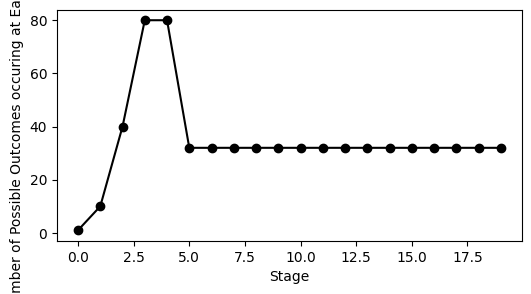

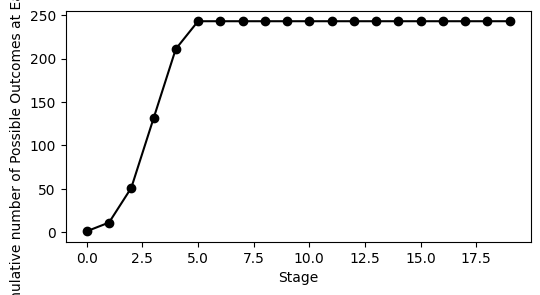

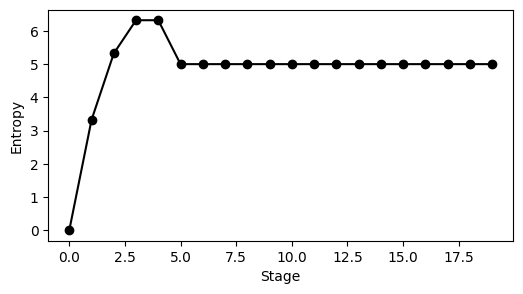

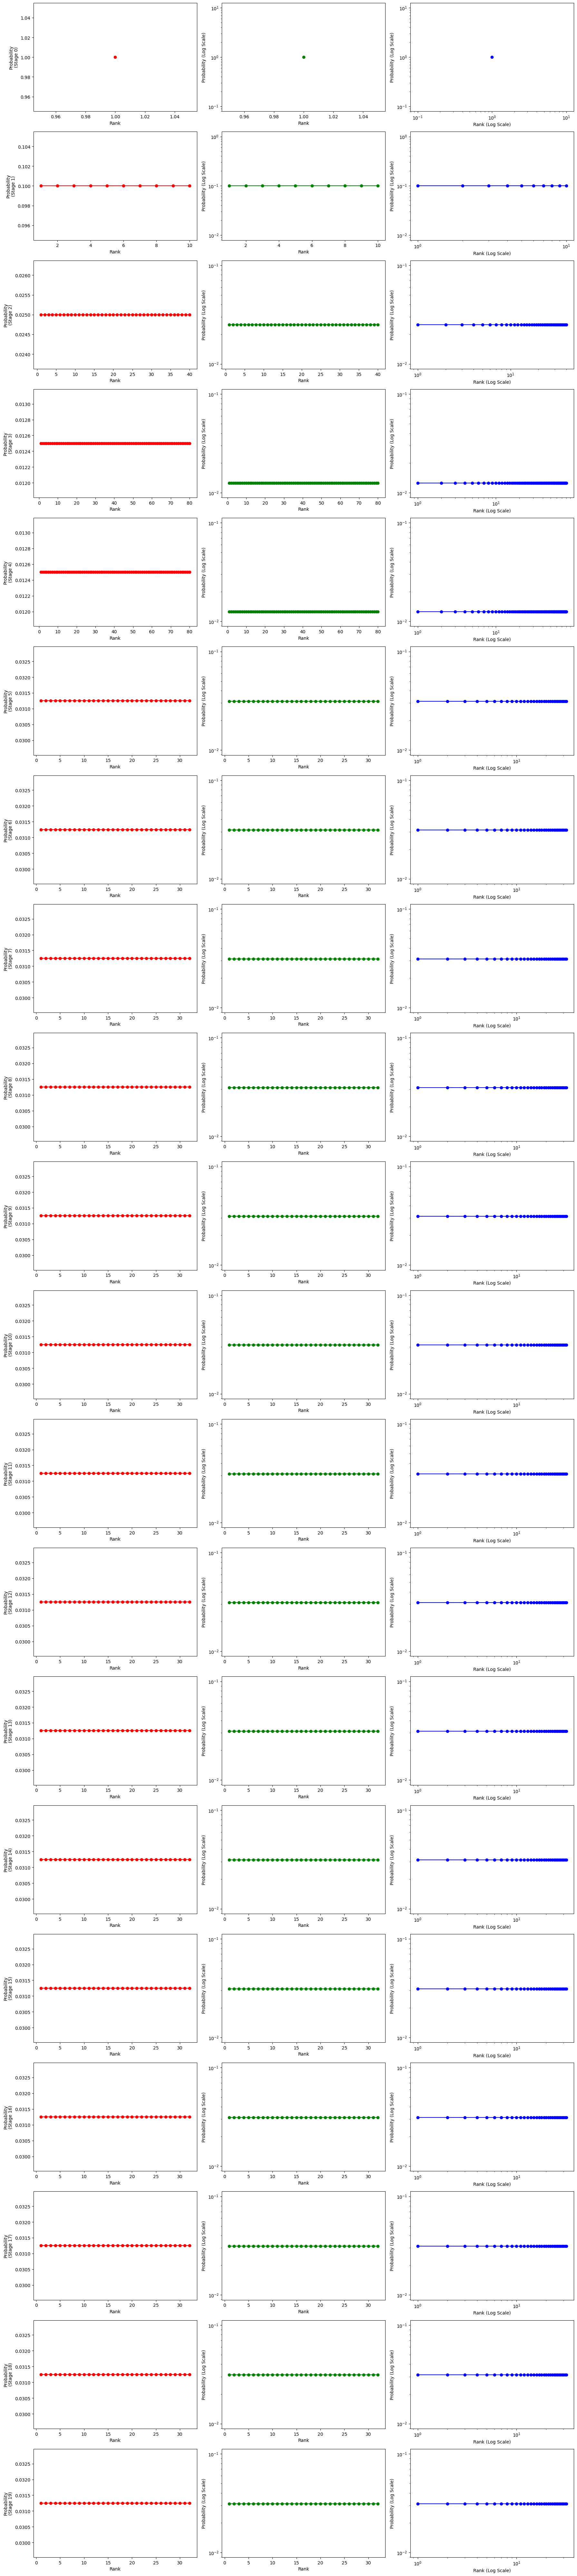

In [18]:
#Sequence that simulates Elowitz's trits (Memior paper)
print("Elowitz's trits sequence")
DNA_sequence_Elowitzstrits=[

# Group 1
'AA', 'alpha', 'a',
'BB', 'A', 'ALPHA',
'CC', 'beta', 'b',

# Group 2
'DD', 'gamma', 'c',
'EE', 'C', 'GAMMA',
'FF', 'delta', 'd',

# Group 3
'GG', 'epsilon', 'e',
'HH', 'E', 'EPSILON',
'II', 'zeta', 'f',

# Group 4
'JJ', 'eta', 'g',
'KK', 'G', 'ETA',
'LL', 'theta', 'h',

# Group 5
'MM', 'iota', 'i',
'NN', 'I', 'IOTA',
'OO', 'kappa', 'j',

# # Group 6
# 'PP', 'lambda', 'k',
# 'QQ', 'K', 'LAMBDA',
# 'RR', 'mu', 'l',

# # Group 7
# 'SS', 'nu', 'm',
# 'TT', 'M', 'NU',
# 'UU', 'xi', 'n',

# # Group 8
# 'VV', 'omicron', 'o',
# 'WW', 'O', 'OMICRON',
# 'XX', 'pi', 'p',

# # Group 9
# 'YY', 'rho', 'q',
# 'ZZ', 'Q', 'RHO',
# 'AAA', 'sigma', 'r',

# # Group 10
# 'BBB', 'tau', 's',
# 'CCC', 'S', 'TAU',
# 'DDD', 'upsilon', 't'
]

pairs_pool_Elowitzstrits=[(['A','ALPHA'],['B','BETA']),
(['C','GAMMA'],['D','DELTA']),
(['E','EPSILON'],['F','ZETA']),
(['G','ETA'],['H','THETA']),
(['I','IOTA'],['J','KAPPA'])
# (['K','LAMBDA'],['L','MU']),
# (['M','NU'],['N','XI']),
# (['O','OMICRON'],['P','PI']),
# (['Q','RHO'],['R','SIGMA']),
# (['S','TAU'],['T','UPSILON'])
]
outcome_list_Elowitzstrits=run_probability_calculation_and_plot_IS110(DNA_sequence_Elowitzstrits, pairs_pool_Elowitzstrits,  plot=1,rank=1)


IS110 single active site sequence


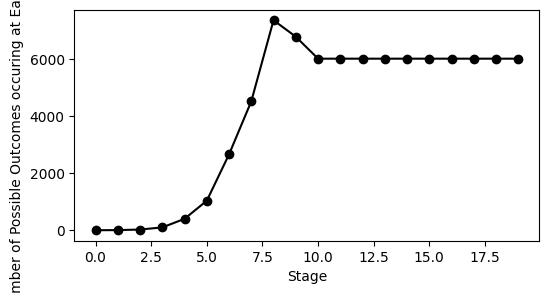

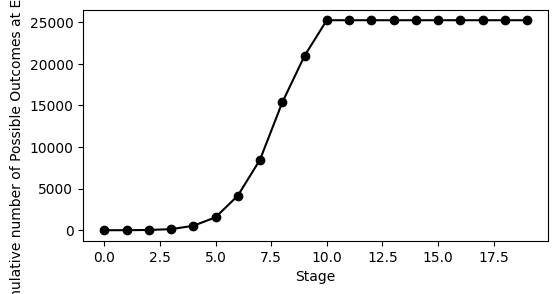

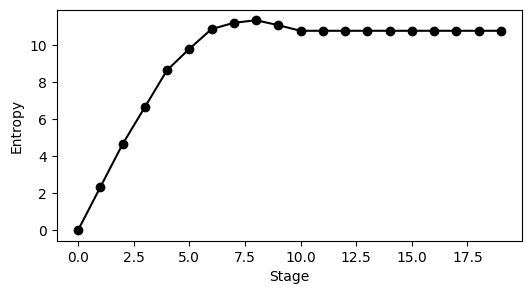

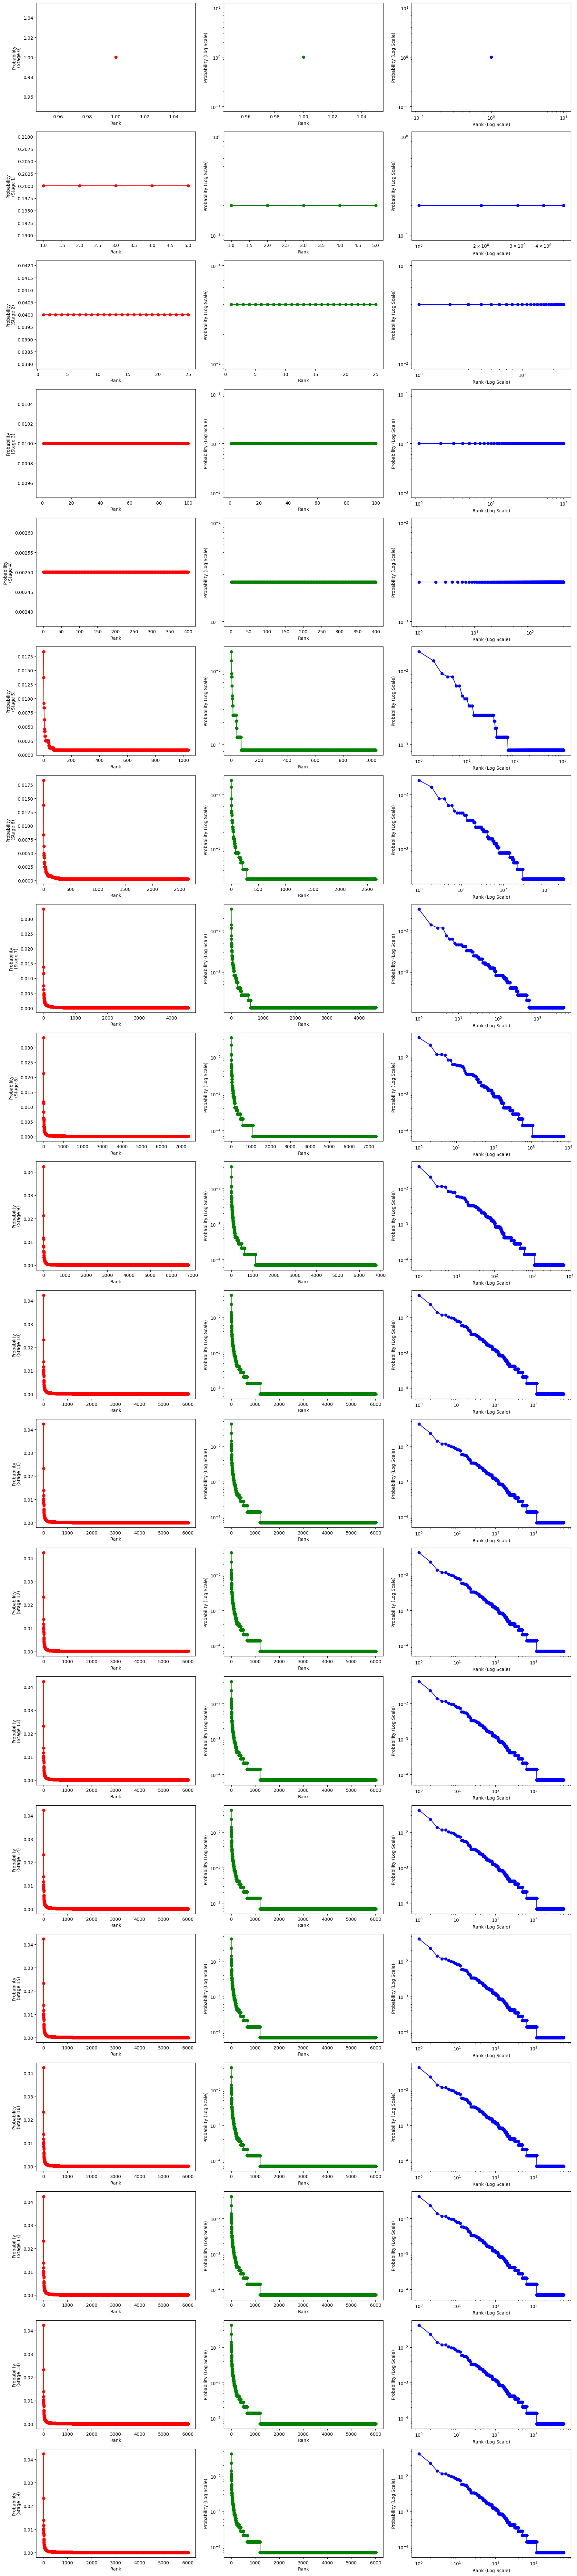

In [19]:
#Sequence with single active site (IS110)
print("IS110 single active site sequence")
DNA_sequence_IS110=[
'ONE', 'A', 'ALPHA',
'TWO','A','ALPHA',
'THREE', 'A', 'ALPHA',
'FOUR', 'A', 'ALPHA',
'FIVE','A', 'ALPHA',
'SIX','A', 'GAMMA',
'SEVEN','beta', 'b',
'EIGHT','beta', 'b',
'NINE','beta', 'b',
'TEN','beta', 'b',
'ELEVEN','beta', 'b',
'TWELVE'
]
pairs_pool_IS110=[(['A','GAMMA'],['B','BETA']),(['A','ALPHA'],['B','GAMMA'])]
outcome_list_IS110= run_probability_calculation_and_plot_IS110(DNA_sequence_IS110,pairs_pool_IS110,plot=1,rank=1)

Polylox sequence


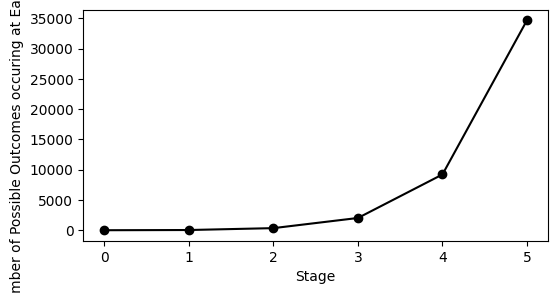

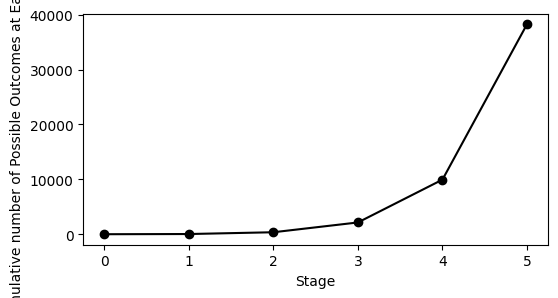

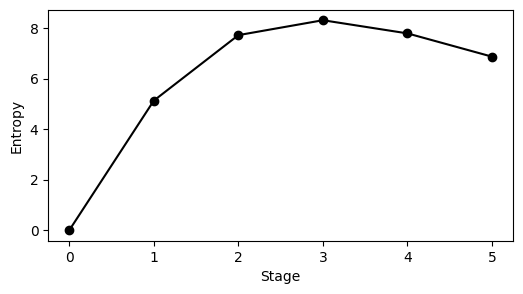

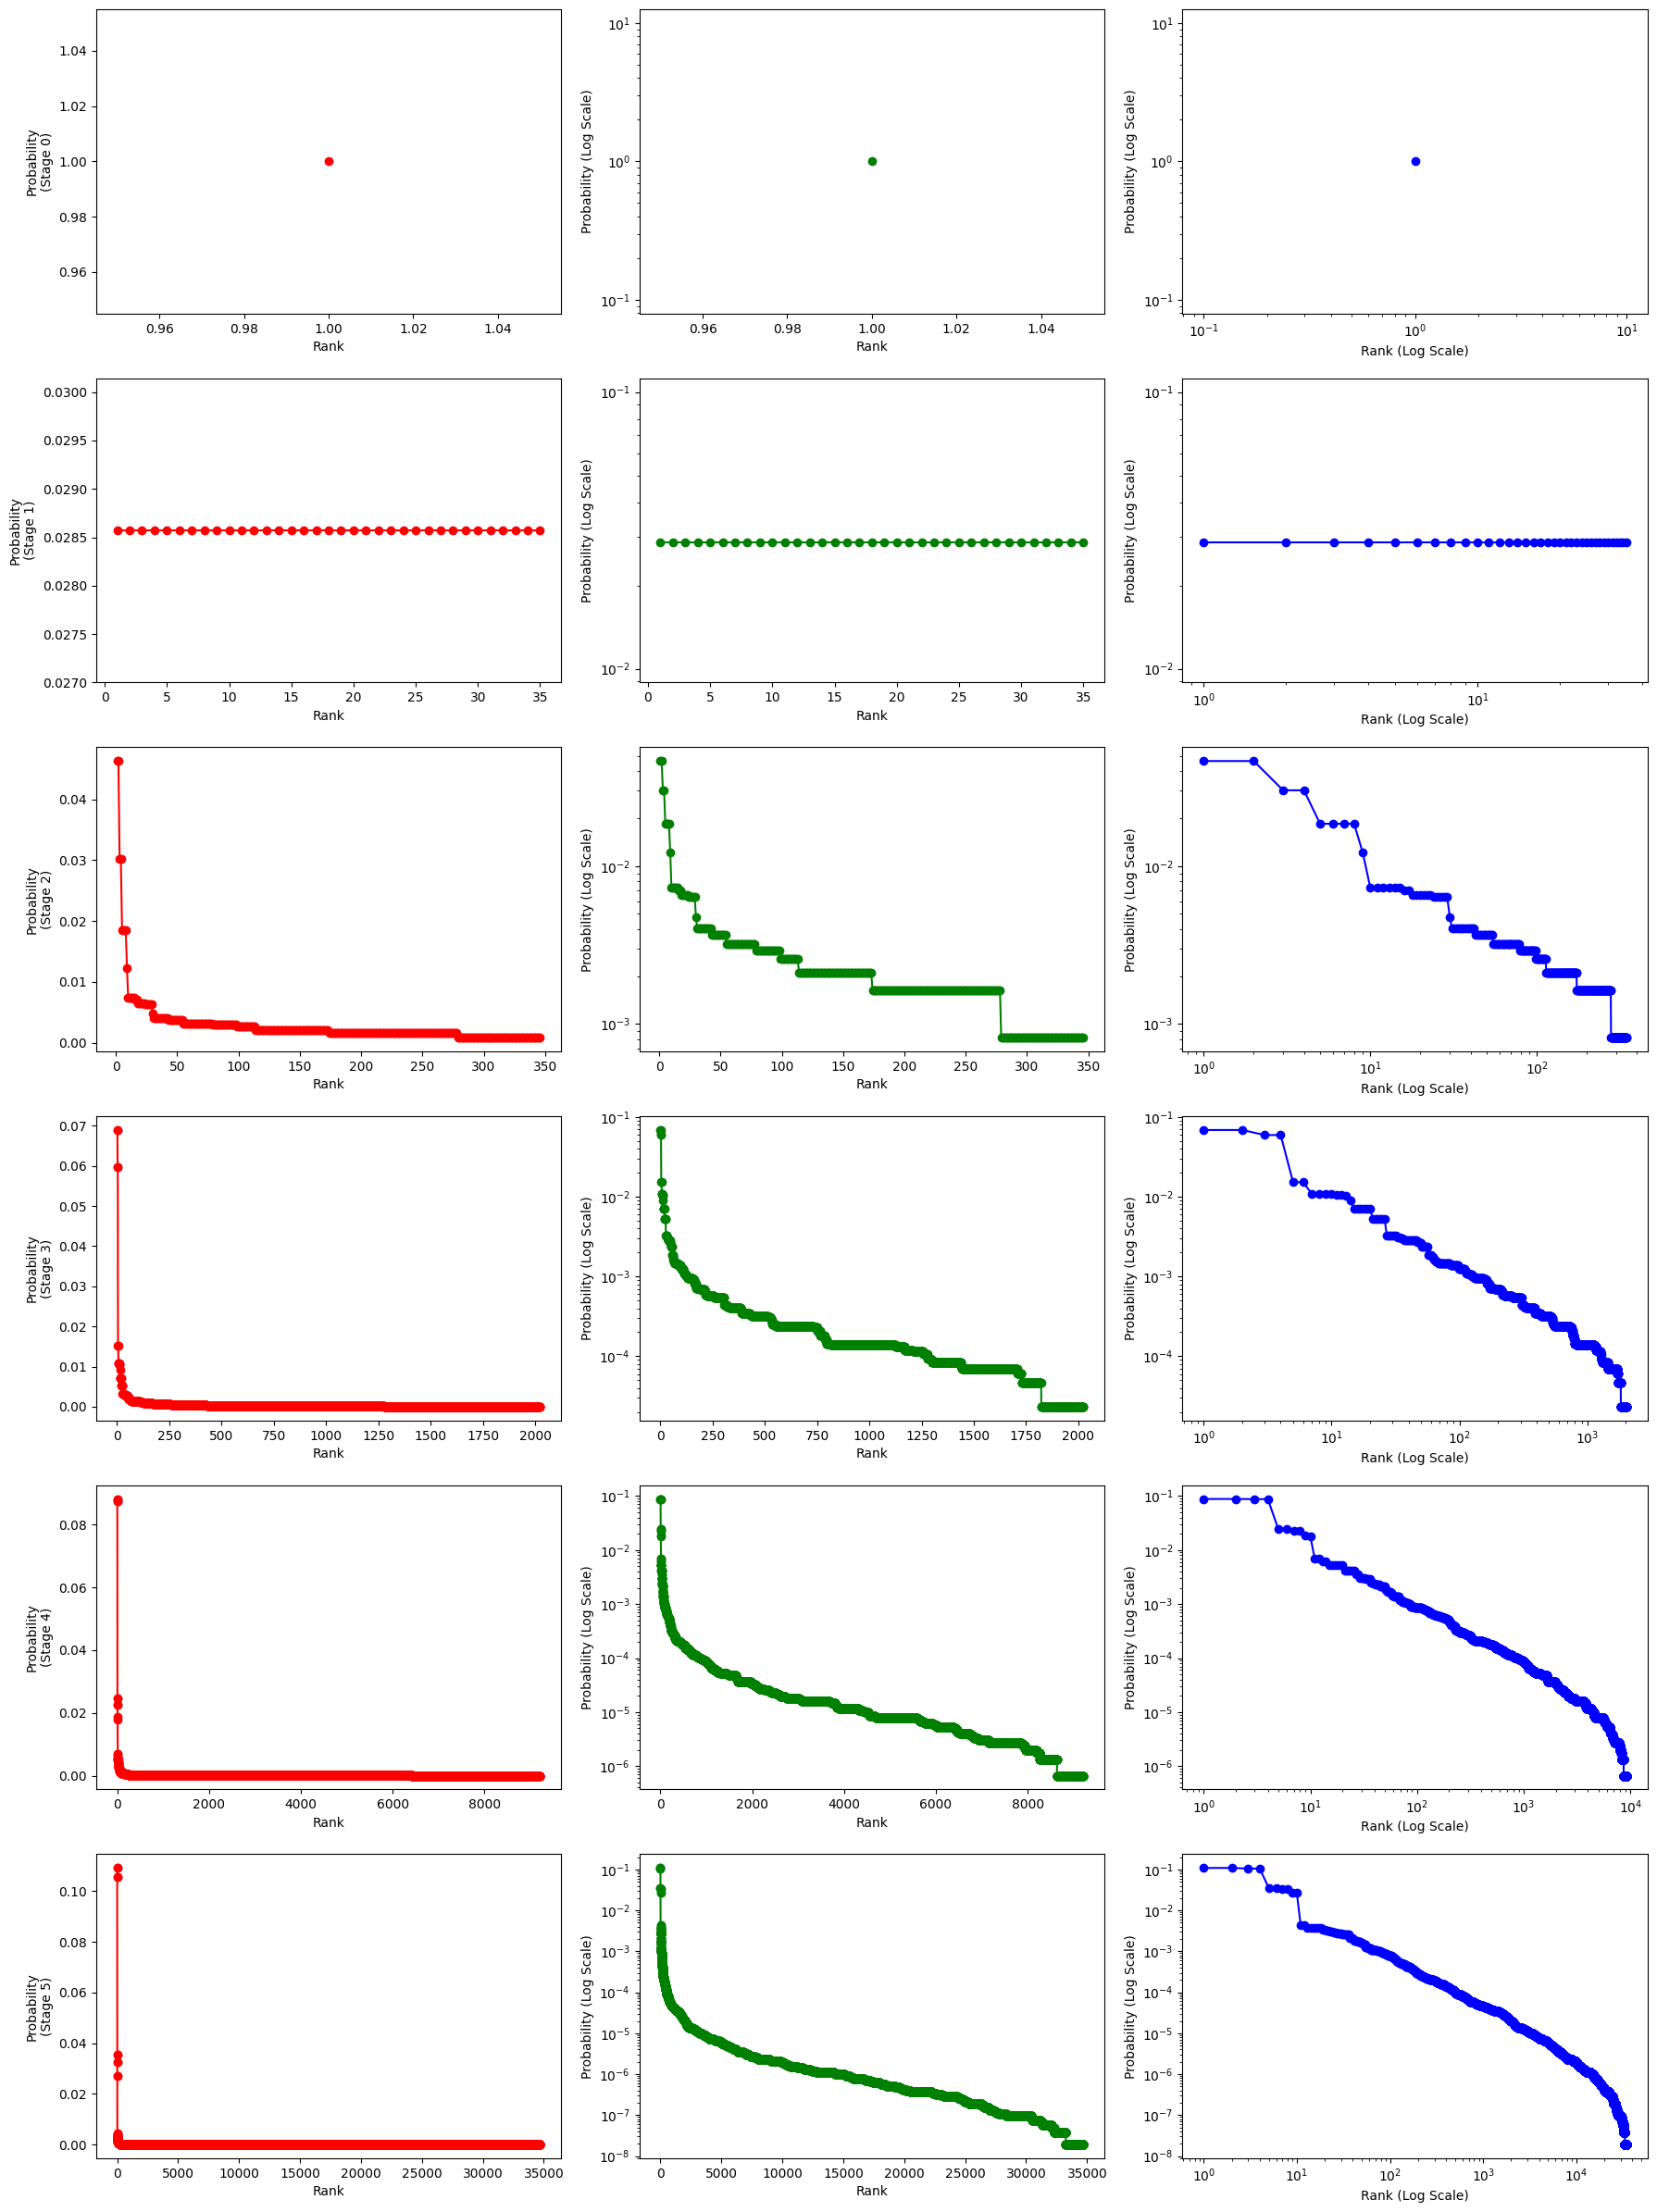

In [20]:
#Sequence that simulates polylox
print("Polylox sequence")
DNA_sequence_polylox=[
'ONE', 'A', 'ALPHA',
'TWO', 'alpha', 'a',
'THREE','A','ALPHA',
'FOUR','alpha','a',
'FIVE', 'A', 'ALPHA',
'SIX', 'alpha', 'a',
'SEVEN','A','ALPHA',
'EIGHT','alpha','a',
'NINE', 'A', 'ALPHA',
'TEN', 'alpha', 'a',
'ELEVEN'
]
pairs_pool_polylox=[(['A','ALPHA'],['A','ALPHA'])]
outcome_lists_polylox= run_probability_calculation_and_plot_IS110(DNA_sequence_polylox,pairs_pool_polylox, plot=1,rank=1,numberofevents=6)



In [21]:
# #Check if it is equivalent to polylox code
# probsum = 0
# num_of_possible_outcomes = np.zeros(numberofevents)
# total_num_of_outcomes = np.zeros(numberofevents)
# entropy = np.zeros(numberofevents)
# initial_dict=Counter()
# for stage in range(numberofevents):
#     probsum = np.sum(list(outcome_lists[stage].values()))
#     if (probsum-1)> 0.01 or (probsum-1)<-0.01:
#         raise ValueError(f"Stage {stage} does not sum to 1, it sums to {probsum}. Please check the input data or the calculation logic.")
#     entropy[stage] = -np.sum([p * np.log2(p) for p in outcome_lists[stage].values() if p > 0])
#     num_of_possible_outcomes[stage] = len(outcome_lists[stage])
#     initial_dict.update(outcome_lists[stage])
#     total_num_of_outcomes[stage] = len(initial_dict)

# print(entropy)
# print(num_of_possible_outcomes)
# print(total_num_of_outcomes)
# # array([-0.        ,  2.5849625 ,  3.169925  ,  3.04091945,  2.80927301,
# #         2.59864575,  2.42685312,  2.29308307,  2.19162766,  2.11601637,
# #         2.06037809,  2.01983502,  1.99052144,  1.96946268,  1.95441562,
# #         1.94371367])
# # array([ 1.,  7., 15., 19., 20., 20., 20., 20., 20., 20., 20., 20., 20.,
# #        20., 20., 20.])

In [22]:
#import pickle
with open('my_variable.pkl', 'rb') as f:
    my_variable = pickle.load(f)

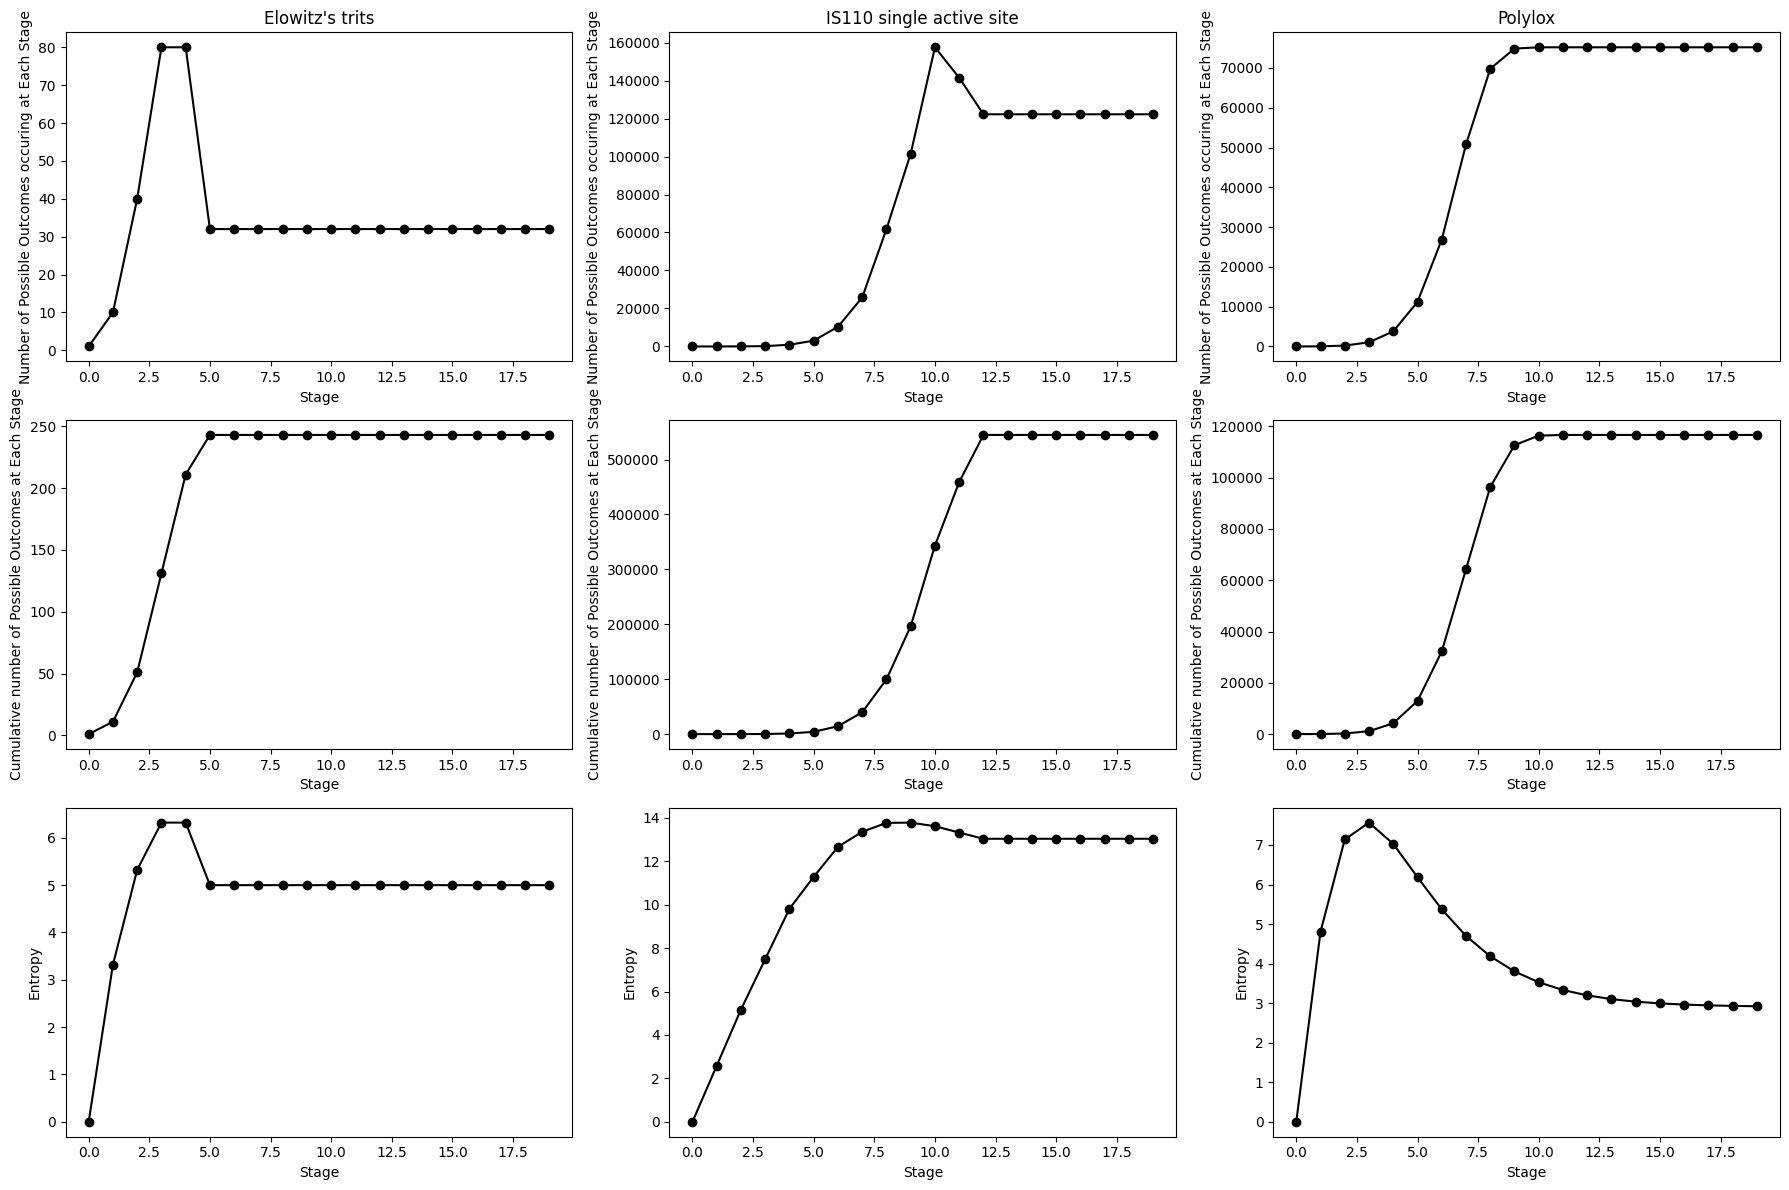

In [36]:
# Example data for demonstration
comparison_list = [outcome_list_Elowitzstrits,outcome_list_IS110, my_variable]
numberofevents=20

fig, axes = plt.subplots(3, 3, figsize=(18, 12))  # 3 rows, 3 columns
axes[0, 0].set_title('Elowitz\'s trits')
axes[0, 1].set_title('IS110 single active site')
axes[0, 2].set_title('Polylox')
for col in range(3):
    outcome_list=comparison_list[col] 
    probsum = 0
    num_of_possible_outcomes = np.zeros(numberofevents)
    total_num_of_outcomes = np.zeros(numberofevents)
    entropy = np.zeros(numberofevents)
    initial_dict=Counter()
    for stage in range(numberofevents):
        probsum = np.sum(list(outcome_list[stage].values()))
        if (probsum-1)> 0.01 or (probsum-1)<-0.01:
            raise ValueError(f"Stage {stage} does not sum to 1, it sums to {probsum}. Please check the input data or the calculation logic.")
        entropy[stage] = -np.sum([p * np.log2(p) for p in outcome_list[stage].values() if p > 0])
        num_of_possible_outcomes[stage] = len(outcome_list[stage])
        initial_dict.update(outcome_list[stage])
        total_num_of_outcomes[stage] = len(initial_dict)
        

    # Plot number of possible outcomes
    #axes[0, col].figure(figsize=(6, 3))
    axes[0, col].plot(num_of_possible_outcomes, marker='o', linestyle='-', color='k')
    axes[0, col].set_xlabel('Stage')
    axes[0, col].set_ylabel('Number of Possible Outcomes occuring at Each Stage')
    #axes[0, col].ylim(0, np.max(num_of_possible_outcomes) * 1.1)

    # Plot cumulative number of possible outcomes
    #axes[1, col].figure(figsize=(6, 3))
    axes[1, col].plot(total_num_of_outcomes, marker='o', linestyle='-', color='k')
    axes[1, col].set_xlabel('Stage')
    axes[1, col].set_ylabel('Cumulative number of Possible Outcomes at Each Stage')
    #axes[1, col].ylim(0, np.max(num_of_possible_outcomes) * 1.1)

    # Plot entropy
    #axes[2, col].figure(figsize=(6, 3))
    axes[2, col].plot(entropy, marker='o', linestyle='-', color='k')
    axes[2, col].set_xlabel('Stage')
    axes[2, col].set_ylabel('Entropy')
    #axes[2, col].ylim(0, np.max(entropy) * 1.1)

    # Plot ranked probabilities
    #plot_ranked_probabilities(outcome_list) if rank==1 else None


plt.tight_layout()
plt.show()

Calculating for IS110 sequence 1
Calculating for IS110 sequence 2
Calculating for IS110 sequence 3
Calculating for IS110 sequence 4
Calculating for IS110 sequence 5
Calculating for IS110 sequence 6


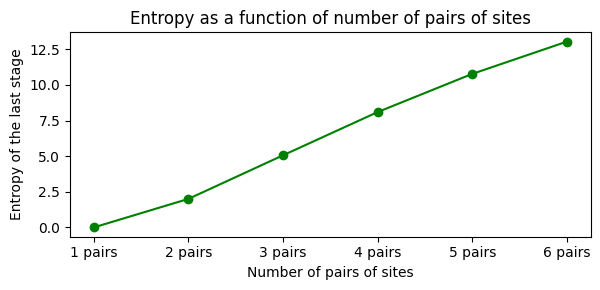

In [34]:
pairs_pool_IS110=[(['A','GAMMA'],['B','BETA']),(['A','ALPHA'],['B','GAMMA'])]
DNA_sequence_IS110_1pairs=[
'ONE', 'A', 'ALPHA',
'TWO', 'A', 'GAMMA',
'THREE','beta', 'b',
'FOUR'
]

DNA_sequence_IS110_2pairs=[
'ONE', 'A', 'ALPHA',
'TWO', 'A', 'ALPHA',
'THREE', 'A', 'GAMMA',
'FOUR','beta', 'b',
'FIVE','beta', 'b',
'SIX'
]

DNA_sequence_IS110_3pairs=[
'ONE', 'A', 'ALPHA',
'TWO', 'A', 'ALPHA',
'THREE', 'A', 'ALPHA',
'FOUR', 'A', 'GAMMA',
'FIVE','beta', 'b',
'SIX','beta', 'b',
'SEVEN','beta', 'b',
'EIGHT'
]

DNA_sequence_IS110_4pairs=[
'ONE', 'A', 'ALPHA',
'TWO', 'A', 'ALPHA',
'THREE', 'A', 'ALPHA',
'FOUR', 'A', 'ALPHA',
'FIVE', 'A', 'GAMMA',
'SIX','beta', 'b',
'SEVEN','beta', 'b',
'EIGHT','beta', 'b',
'NINE','beta', 'b',
'TEN'
]

DNA_sequence_IS110_5pairs=[
'ONE', 'A', 'ALPHA',
'TWO', 'A', 'ALPHA',
'THREE', 'A', 'ALPHA',
'FOUR', 'A', 'ALPHA',
'FIVE', 'A', 'ALPHA',
'SIX', 'A', 'GAMMA',
'SEVEN','beta', 'b',
'EIGHT','beta', 'b',
'NINE','beta', 'b',
'TEN','beta', 'b',
'ELEVEN','beta', 'b',
'TWELVE'
]

DNA_sequence_IS110_6pairs=[
'ONE', 'A', 'ALPHA',
'TWO', 'A', 'ALPHA',
'THREE', 'A', 'ALPHA',
'FOUR', 'A', 'ALPHA',
'FIVE', 'A', 'ALPHA',
'SIX', 'A', 'ALPHA',
'SEVEN', 'A', 'GAMMA',
'EIGHT','beta', 'b',
'NINE','beta', 'b',
'TEN','beta', 'b',
'ELEVEN','beta', 'b',
'TWELVE','beta', 'b',
'THIRTEEN','beta', 'b',
'FOURTEEN'
]

DNA_sequence_IS110_7pairs=[
'ONE', 'A', 'ALPHA',
'TWO', 'A', 'ALPHA',
'THREE', 'A', 'ALPHA',
'FOUR', 'A', 'ALPHA',
'FIVE', 'A', 'ALPHA',
'SIX', 'A', 'ALPHA',
'SEVEN', 'A', 'ALPHA',
'EIGHT', 'A', 'GAMMA',
'NINE','beta', 'b',
'TEN','beta', 'b',
'ELEVEN','beta', 'b',
'TWELVE','beta', 'b',
'THIRTEEN','beta', 'b',
'FOURTEEN','beta', 'b',
'FIFTEEN','beta', 'b',
'SIXTEEN'
]

DNA_sequence_IS110_8pairs=[
'ONE', 'A', 'ALPHA',
'TWO', 'A', 'ALPHA',
'THREE', 'A', 'ALPHA',
'FOUR', 'A', 'ALPHA',
'FIVE', 'A', 'ALPHA',
'SIX', 'A', 'ALPHA',
'SEVEN', 'A', 'ALPHA',
'EIGHT', 'A', 'ALPHA',
'NINE', 'A', 'GAMMA',
'TEN','beta', 'b',
'ELEVEN','beta', 'b',
'TWELVE','beta', 'b',
'THIRTEEN','beta', 'b',
'FOURTEEN','beta', 'b',
'FIFTEEN','beta', 'b',
'SIXTEEN','beta', 'b',
'SEVENTEEN','beta', 'b',
'EIGHTEEN'
]

DNA_sequence_IS110_9pairs=[
'ONE', 'A', 'ALPHA',
'TWO', 'A', 'ALPHA',
'THREE', 'A', 'ALPHA',
'FOUR', 'A', 'ALPHA',
'FIVE', 'A', 'ALPHA',
'SIX', 'A', 'ALPHA',
'SEVEN', 'A', 'ALPHA',
'EIGHT', 'A', 'ALPHA',
'NINE', 'A', 'ALPHA',
'TEN', 'A', 'GAMMA',
'ELEVEN','beta', 'b',
'TWELVE','beta', 'b',
'THIRTEEN','beta', 'b',
'FOURTEEN','beta', 'b',
'FIFTEEN','beta', 'b',
'SIXTEEN','beta', 'b',
'SEVENTEEN','beta', 'b',
'EIGHTEEN','beta', 'b',
'NINETEEN','beta', 'b',
'TWENTY'
]

DNA_sequence_IS110_10pairs=[
'ONE', 'A', 'ALPHA',
'TWO', 'A', 'ALPHA',
'THREE', 'A', 'ALPHA',
'FOUR', 'A', 'ALPHA',
'FIVE', 'A', 'ALPHA',
'SIX', 'A', 'ALPHA',
'SEVEN', 'A', 'ALPHA',
'EIGHT', 'A', 'ALPHA',
'NINE', 'A', 'ALPHA',
'TEN', 'A', 'ALPHA',
'ELEVEN', 'A', 'GAMMA',
'TWELVE','beta', 'b',
'THIRTEEN','beta', 'b',
'FOURTEEN','beta', 'b',
'FIFTEEN','beta', 'b',
'SIXTEEN','beta', 'b',
'SEVENTEEN','beta', 'b',
'EIGHTEEN','beta', 'b',
'NINETEEN','beta', 'b',
'TWENTY','beta', 'b',
'TWENTYONE','beta', 'b',
'TWENTYTWO']
IS110_lists = [
    DNA_sequence_IS110_1pairs,
    DNA_sequence_IS110_2pairs,
    DNA_sequence_IS110_3pairs,
    DNA_sequence_IS110_4pairs,
    DNA_sequence_IS110_5pairs,
    DNA_sequence_IS110_6pairs,
    # DNA_sequence_IS110_7pairs,
    # DNA_sequence_IS110_8pairs,
    # DNA_sequence_IS110_9pairs,
    # DNA_sequence_IS110_10pairs
]
entropy = np.zeros(len(IS110_lists))
for i in range(len(IS110_lists)):
    print(f"Calculating for IS110 sequence {i+1}")
    DNA_sequence_IS110 = IS110_lists[i]
    outcome_list_IS110= run_probability_calculation_and_plot_IS110(DNA_sequence_IS110,pairs_pool_IS110,plot=0)
     
    entropy[i] = -np.sum([p * np.log2(p) for p in outcome_list_IS110[-1].values() if p > 0])

#plot the entropy of IS110 sequences
plt.figure(figsize=(6, 3))
plt.plot(entropy, marker='o', linestyle='-', color='g')
plt.xticks(range(len(IS110_lists)), [f'{i+1} pairs' for i in range(len(IS110_lists))])
plt.xlabel('Number of pairs of sites')
plt.ylabel('Entropy of the last stage')
plt.title('Entropy as a function of number of pairs of sites')
plt.tight_layout()
plt.show()

In [ ]:
#Borrowing this notebook to run entropy calculations on Elowitz's trits
# Group definitions
group1 = ['AA', 'alpha', 'a', 'BB', 'A', 'ALPHA', 'CC', 'beta', 'b']
group2 = ['DD', 'gamma', 'c', 'EE', 'C', 'GAMMA', 'FF', 'delta', 'd']
group3 = ['GG', 'epsilon', 'e', 'HH', 'E', 'EPSILON', 'II', 'zeta', 'f']
group4 = ['JJ', 'eta', 'g', 'KK', 'G', 'ETA', 'LL', 'theta', 'h']
group5 = ['MM', 'iota', 'i', 'NN', 'I', 'IOTA', 'OO', 'kappa', 'j']
group6 = ['PP', 'lambda', 'k', 'QQ', 'K', 'LAMBDA', 'RR', 'mu', 'l']
group7 = ['SS', 'nu', 'm', 'TT', 'M', 'NU', 'UU', 'xi', 'n']
group8 = ['VV', 'omicron', 'o', 'WW', 'O', 'OMICRON', 'XX', 'pi', 'p']
group9 = ['YY', 'rho', 'q', 'ZZ', 'Q', 'RHO', 'AAA', 'sigma', 'r']
group10 = ['BBB', 'tau', 's', 'CCC', 'S', 'TAU', 'DDD', 'upsilon', 't']

# Cumulative lists
Elowitzs_trits_seq_1 = group1
Elowitzs_trits_seq_2 = group1 + group2
Elowitzs_trits_seq_3 = group1 + group2 + group3
Elowitzs_trits_seq_4 = group1 + group2 + group3 + group4
Elowitzs_trits_seq_5 = group1 + group2 + group3 + group4 + group5
Elowitzs_trits_seq_6 = group1 + group2 + group3 + group4 + group5 + group6
Elowitzs_trits_seq_7 = group1 + group2 + group3 + group4 + group5 + group6 + group7
Elowitzs_trits_seq_8 = group1 + group2 + group3 + group4 + group5 + group6 + group7 + group8
Elowitzs_trits_seq_9 = group1 + group2 + group3 + group4 + group5 + group6 + group7 + group8 + group9
Elowitzs_trits_seq_10 = group1 + group2 + group3 + group4 + group5 + group6 + group7 + group8 + group9 + group10


pairs_pool_Elowitzstrits=[(['A','ALPHA'],['B','BETA']),
(['C','GAMMA'],['D','DELTA']),
(['E','EPSILON'],['F','ZETA']),
(['G','ETA'],['H','THETA']),
(['I','IOTA'],['J','KAPPA']),
(['K','LAMBDA'],['L','MU']),
(['M','NU'],['N','XI']),
(['O','OMICRON'],['P','PI']),
(['Q','RHO'],['R','SIGMA']),
(['S','TAU'],['T','UPSILON'])
]
Elowitzs_list=[Elowitzs_trits_seq_1, Elowitzs_trits_seq_2, Elowitzs_trits_seq_3, Elowitzs_trits_seq_4,
               Elowitzs_trits_seq_5, Elowitzs_trits_seq_6, Elowitzs_trits_seq_7,
               Elowitzs_trits_seq_8, Elowitzs_trits_seq_9, Elowitzs_trits_seq_10]

               # Calculate and plot entropy for Elowitz trits sequences
entropy = np.zeros(len(Elowitzs_list))
for i in range(10):
    print(f"Calculating for Elowitz trits sequence {i+1}")
    DNA_sequence_Elowitz = Elowitzs_list[i]
    outcome_list_Elowitz = run_probability_calculation_and_plot_IS110(DNA_sequence_Elowitz, pairs_pool_Elowitzstrits, plot=0,numberofevents=15)
    # Use the second to last stage for entropy, as in your original code
    entropy[i] = -np.sum([p * np.log2(p) for p in outcome_list_Elowitz[-1].values() if p > 0])

plt.figure(figsize=(6, 3))
plt.plot(entropy, marker='o', linestyle='-', color='g')
plt.xticks(range(len(Elowitzs_list)), [f'{i+1} ' for i in range(len(Elowitzs_list))])
plt.xlabel('Number of groups in Elowitz trits sequence')
plt.ylabel('Entropy of the last stage')
plt.title('Entropy as a function of number of groups (Elowitz trits)')
plt.tight_layout()
plt.show()